In [1]:
import argparse
import subprocess, os
from process_data import *
import random
import numpy as np
import torch
from data.dataset import create_datasets
from Generator.Generator import generator
import yaml
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
stream=open("Configs/MNIST/VAE.yaml", "r")
argsdict=yaml.safe_load(stream)
if argsdict['computer'] == 'home':
    argsdict['path'] = "/media/frederic/VAETI"
elif argsdict['computer'] == 'labo':
    argsdict['path'] = "/u/piedboef/Documents/VAETI"

if argsdict['dataset'] == "SST2":
    categories = ["neg", "pos"]
elif argsdict['dataset'] == "TREC6":
    categories = ["ABBR", "DESC", "ENTY", "HUM", "LOC", "NUM"]
elif argsdict['dataset'] == "FakeNews":
    categories = ["Fake", "Real"]
elif argsdict['dataset'] == "QNLI":
    categories = ["entailment", "not_entailment"]
elif argsdict['dataset'] == "Irony":
    categories = ["NotIro", "Iro"]
elif argsdict['dataset'] == "IronyB":
    categories = ["Clash", "Situational", "Other", "NotIro"]
elif argsdict['dataset'] == 'MNIST':
    categories = [0,1,2,3,4,5,6,7,8,9]
else:
    raise ValueError("Dataset not found")
argsdict['categories'] = categories

argdict=argsdict
    

In [2]:
train, dev, test=create_datasets(argdict)
Gen = generator(argdict, train, dev, test)
Gen.train()

Think about why there aint no embedding dropout on encoder?
Think about why there aint no embedding dropout on encoder?
VAE_Annealing_model(
  (encoder): encoder(
    (model): GRU_Encoder(
      (embedding): Embedding(14716, 300)
      (rnn): GRU(300, 512, batch_first=True)
      (hidden2mean): Linear(in_features=512, out_features=5, bias=True)
      (hidden2logv): Linear(in_features=512, out_features=5, bias=True)
    )
  )
  (decoder): decoder(
    (model): GRU_Decoder(
      (latent2hidden): Linear(in_features=5, out_features=512, bias=True)
      (embedding): Embedding(14716, 300)
      (rnn): GRU(300, 512, batch_first=True)
      (outputs2vocab): Linear(in_features=512, out_features=14716, bias=True)
    )
  )
)
TRAIN Epoch 0/30, Mean ELBO 139.2926040789403, Mean NLL 139.09230041503906, Mean KL div 10.986664772033691 KL Weight 0.02150984475089023
DEV Epoch 0/30, Mean ELBO 131.96490042550224, Mean NLL 131.7869415283203, Mean KL div 8.253652572631836 KL Weight 0.021562525670029403
T

/u/piedboef/Documents/VAETI/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/u/piedboef/Documents/VAETI/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


              x          y  labs  \
0    -34.118702 -52.279240   1.0   
1    -21.474037 -40.310452   0.0   
2    -37.995369  27.281136   0.0   
3     29.081827  20.324427   1.0   
4     38.056541 -24.716887   1.0   
...         ...        ...   ...   
6915  29.944197 -33.473854   1.0   
6916  25.490673   8.651177   0.0   
6917  -3.603227  78.015358   0.0   
6918  -8.265487 -32.351330   0.0   
6919 -30.960226 -58.163673   1.0   

                                                 points  
0     [-0.850115180015564, -0.030947808176279068, 1....  
1     [0.9739819765090942, 0.6366329193115234, 1.605...  
2     [0.31409162282943726, -1.8898437023162842, 1.3...  
3     [-1.9012365341186523, -0.22458669543266296, -0...  
4     [1.8279646635055542, 0.02884170413017273, -0.6...  
...                                                 ...  
6915  [0.23190248012542725, 0.28226056694984436, -1....  
6916  [-0.6505721211433411, -1.0763835906982422, -0....  
6917  [-0.03246589004993439, -1.4397327899932

NameError: name 'sdffd' is not defined

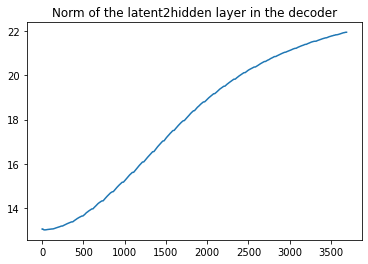

In [3]:
y=Gen.generator.model.decoder.norm
x=np.arange(len(y))

plt.plot(x,y)
plt.title("Norm of the latent2hidden layer in the decoder")
plt.show()